In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from functions import *
%config Completer.use_jedi = False
%matplotlib inline

font = {'size': 15}

## Import degli spettri puri e degli spettri di sampling

In [2]:
#definisco i nomi delle colonne da dare 
names=define_names()

### Import degli spettri di sampling
Importo solo il primo dei due campioni che ci sono stati forniti, per lavorare con il secondo o altri o modificare quì sotto o utilizzare l'analisi automatizata con **make**.

In [3]:
#quì importiamo i dati dei sampling in dataframes pandas, la colonna dei numeri d'onda è una unica per tutti
data = pd.read_csv('../data/raw/S1_mapA_11x11.txt', delim_whitespace=True, names=names)
data_bkg = pd.read_csv('../data/raw/S1_bkg_mapA_11x11.txt', delim_whitespace=True, names=names)

### Import degli spettri puri
Sceglaimo di inserire tutti gli spettri puri in una struttura dataframe di Pandas, anche se questi hanno lunghezze divere.

In [4]:
pure_material_names,pure_materials=import_pure_spectra('../data/raw/Database Raman/BANK_LIST.dat','../data/raw/Database Raman/')

## Spettri puri

Andiamo prima di tutto a vedere come sono fatti gli spettri dei materiali puri che, come capiamo subito, sono molto meno rumorosi rispetto agli spettri del nostro campione. 

Notiamo inoltre, guardando i dataframes, che le lunghezze d'onda a cui sono campionati gli spettri di materiale puro sono diverse tra materiali diversi.

Nel compararli con i nostri campioni sarà sicuramente necessaria dunque un'interpolazione lineare.

Di seguito plottiamo come esempio lo **spettro puro dell'Albite**. 

Notiamo come lo spettro è poco rumoroso e non presenti offset significativi inoltre lontano dai picchi (dalle frequenze di assorbimento degli stati rotazionali/vibrazionali delle molecole) lo spettro va a zero. 

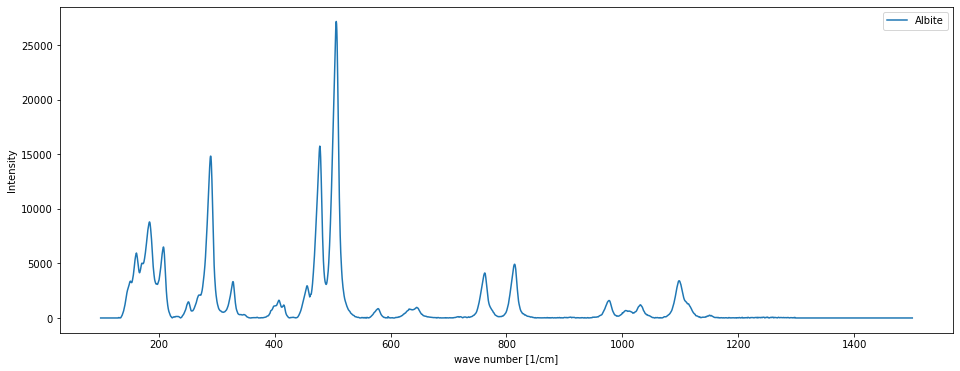

In [5]:
raman_plot()
plt.plot(pure_materials.Albite_wn,pure_materials.Albite_I)
plt.legend(['Albite']);
plt.rc('font',**font)

Vogliamo ora comparare diversi spettri puri per imparare il più possibile l'andamento delle curve Raman. Notiamo che gli spettri raman dei materiali puri non sono normalizzati tra di loro. Dato che l'area sotto lo spettro risulta proporzionale al tempo di esposizione della misura (fonte: pdf di introduzione), questa non è una quantità a cui siamo interessati, scegliamo di normalizzare in modo che tutti gli spettri abbiamo area unitaria.

### Normalizzazione degli spettri puri

In [6]:
# qui abbiamo usato dropna per risolvere il problema che alcuni spettri hanno un numero diverso di dati.
# la normalizzazione è fatta utilizzando l'integrazione discreta con trapezi (np.trapaz)
for i in pure_material_names:
    pure_materials[i+'_I']=pure_materials[i+'_I']/np.trapz(abs(pure_materials[i+'_I'].dropna()), x=pure_materials[i+'_wn'].dropna())

Plottiamo dunque di seguito **tutti gli spettri puri normalizzati**.

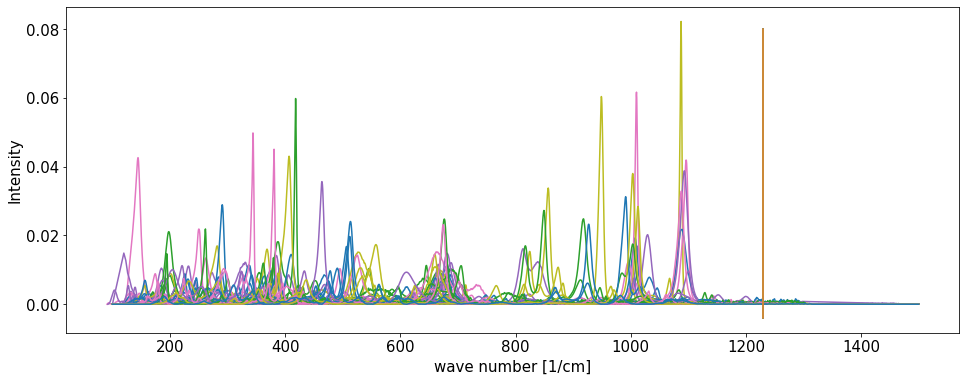

In [7]:
raman_plot()
plt.rc('font',**font)
for i in range(len(pure_material_names)):
    plt.plot(pure_materials[pure_material_names[i]+'_wn'],pure_materials[pure_material_names[i]+'_I'])
    plt.plot([1230,1230],[-0.004,0.08]) #wn oltre la quale gli spettri vanno a zero

Notiamo che nessuno degli spettri puri presenta un rumore rilevante, assumiamo dunque che questi spettri rappresentino gli spettri Raman corretti per i materiali nella lista.

Assumiamo inoltre che i materiali puri dati coprano quelli di cui sono composti i nostri campioni incogniti (anche se questo non fosse vero è sufficente che coprano i materiali principali).

Osservando il grafico appena plottato deduciamo che:

1. **Per numeri d'onda superiori a 1230 $cm^{-1}$ (linea arancione verticale) tutti gli spettri Raman non presentano picchi rilevanti, l'intensità a piccole lunghezze d'onda è nulla.**
2. **Gli spettri Raman, relativamente alle altezze dei picchi, non presentano un offset rilevante. Nella coda del grafico tutti gli spettri Raman vanno a zero.**
3. **Le FWHM dei picchi sono, certe volte, importanti: fino a 100 $cm^{-1}$.**
4. **Lo spettro fino a circa 1230 $cm^{-1}$ è densamente popolato.**

## Spettri incogniti

### Con cosa stiamo lavorando?

Vediamo come sono gli **spettri sperimentali con rumore di background**, di seguito plottiamo i primi trè.

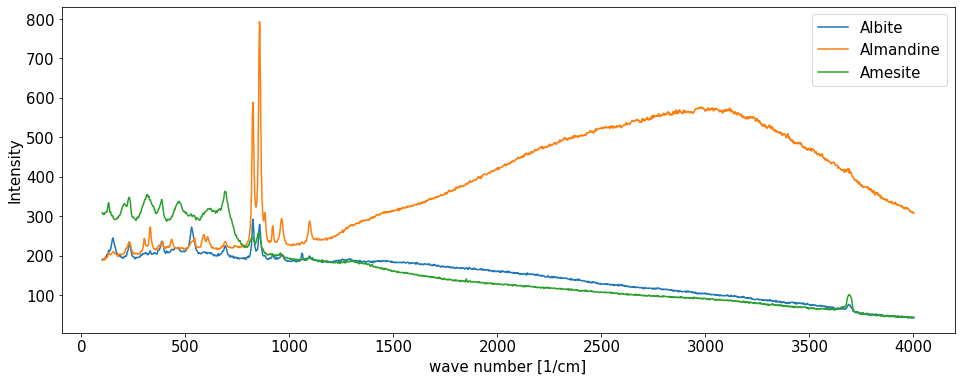

In [8]:
raman_plot()
plt.rc('font',**font)
plt.plot(data.wn,data.r1c1)
plt.plot(data.wn,data.r1c2)
plt.plot(data.wn,data.r1c3)
plt.legend(['row 1 column 1','row 1 column 2','row 1 column 3']);

E qui li plottiamo tutti.

**Capiamo che i tempi di esposizione per punti diversi del campione di materiale sono sensibilmente diversi, come lo è anche la forma del background.** C'e' quindi la necessita' di sottrarre il rumore e normalizzare gli spettri in modo da poterli confrontare.

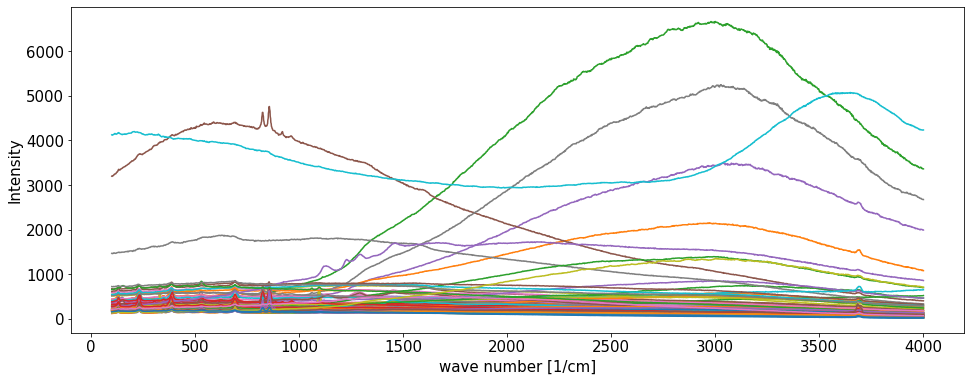

In [9]:
raman_plot()
plt.rc('font',**font)
for temp in names[1:]:
    plt.plot(data.wn,data[temp])

Andiamo a vedere come sono gli **spettri sperimentali con il background rimosso** (già forniti), di seguito come prima i primi tre punti.

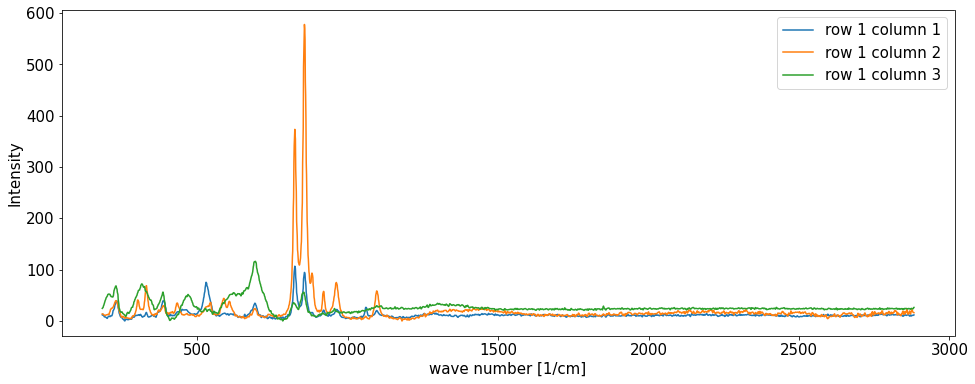

In [10]:
raman_plot()
plt.rc('font',**font)
plt.plot(data_bkg.wn,data_bkg.r1c1)
plt.plot(data_bkg.wn,data_bkg.r1c2)
plt.plot(data_bkg.wn,data_bkg.r1c3)
plt.legend(['row 1 column 1', 'row 1 column 2', 'row 1 column 3']);

E poi tutti.

Quì capiamo che alcuni spettri non rappresenano un segnale fisico dato che non rispettano alcun comportamento visto negli spettri puri: non evidenziano picchi, presentano un'offset significativo e hanno intensità importanti anche per numeri d'onda maggiori di $1230 cm^{-1}$. Questi spettri andrebbero probabilmente rimossi per tutta l'analisi che segue ma tuttavia questo **non è ancora stato implementato**.

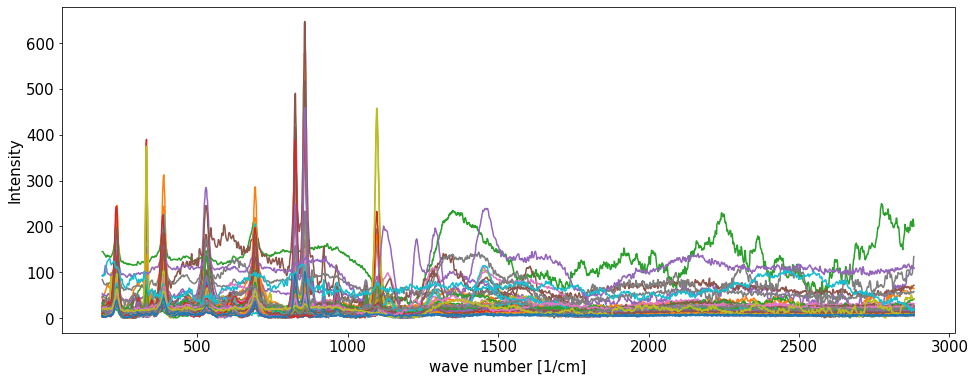

In [11]:
raman_plot()
plt.rc('font',**font)
for temp in names[1:]:
    plt.plot(data_bkg.wn,data_bkg[temp]);

Non ci sembra che il background possa darci informazioni utili e dunque, da qui in poi, tratteremo solo gli spettri a background rimosso.

### Rimozione dell'offset
Come abbiamo visto dagli spettri puri, diversamente dagli spettri incogniti nessuno spettro presentava un offset rilevante. 

Per eliminare/ridurre questo offset utilizziamo il fatto che l'intensita' di tutti gli spettri puri per wave number > 1230 $cm^{-1}$ va a zero.

Imponiamo dunque questo anche agli spettri incogniti: scegliamo di **calcolare l'offset sulla coda e lo sottraiamo a tutto lo spettro**. 

Di seguito un **esempio**.

In [12]:
wn_soglia=1250 #da dove inizia la coda
for i in enumerate(data_bkg.wn):
    if wn_soglia==i[1]:
        element_soglia=i[0] #è l'elemento di soglia, legato al numero d'onda di soglia

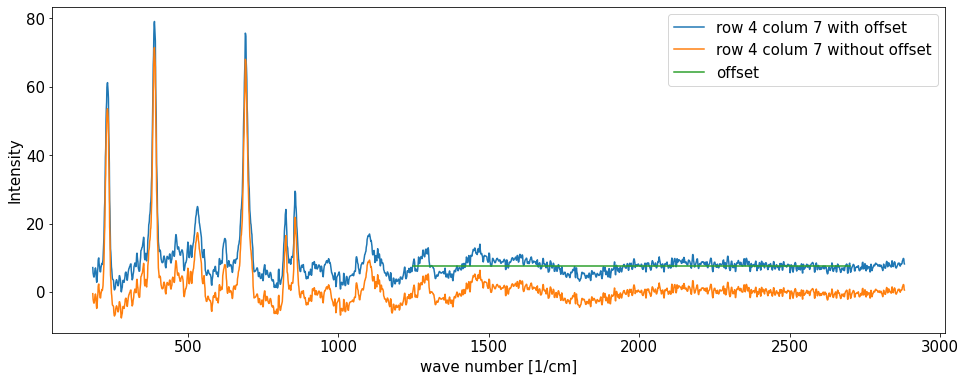

In [13]:
raman_plot()
plt.rc('font',**font)
sample='r4c7' #il sample su cui faccio gli esempi
plt.plot(data_bkg.wn,data_bkg[sample])
offset=data_bkg[sample][element_soglia::].mean()
plt.plot(data_bkg.wn,data_bkg[sample]-offset)

plt.plot([wn_soglia,2700],[offset,offset])
plt.legend(['row 4 colum 7 with offset', 'row 4 colum 7 without offset', 'offset']);

Implementiamo poi il procedimento su tutti i sample. Di seguito il risultato.

In [14]:
for temp in names[1::]:
    offset=data_bkg[temp][element_soglia::].mean()
    data_bkg[temp]=data_bkg[temp]-offset

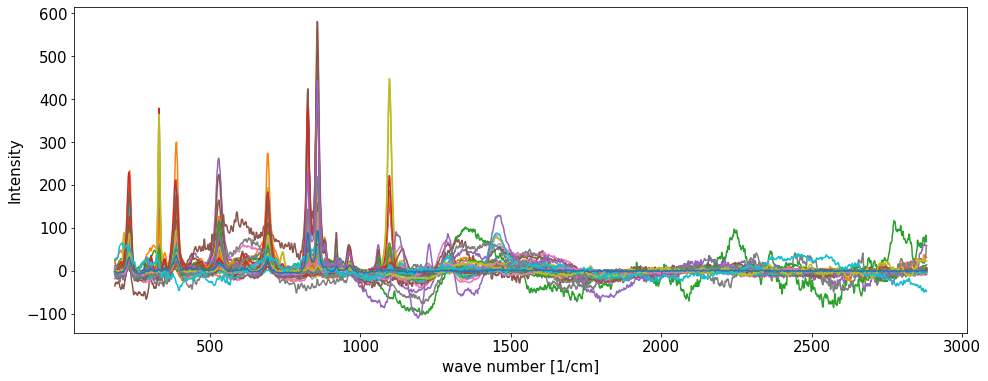

In [15]:
raman_plot()
plt.rc('font',**font)
for temp in names[1:]:
    plt.plot(data_bkg.wn,data_bkg[temp])

### Normalizzazione degli spettri di sample
Anche quì gli spettri non sono normalizzati tra di loro, per confrontarli prima di tutto li normalizziamo.

Scegliamo di **effettuare la normalizzazione calcolando l'integrale solo sulla parte sinistra del grafico**. Questo perchè sceglaimo di non utilizzare la coda del grafico nell'analisi dato che negli spettri puri sopra circa $1230 cm^{-1}$ la coda va a zero. 

In [16]:
for i in names[1:]:
    data_bkg[i]=data_bkg[i]/np.trapz(abs(data_bkg[i][:element_soglia]), x=data_bkg['wn'][0:element_soglia])

Di seguito il risultato: **tutti gli spettri sperimentali normalizzati senza background**.

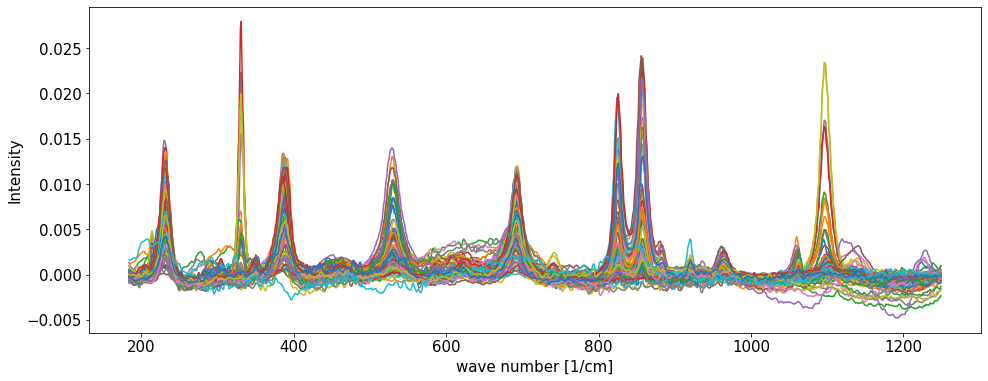

In [17]:
raman_plot()
plt.rc('font',**font)
for temp in names[1:]:
    plt.plot(data_bkg.wn[:element_soglia],data_bkg[temp][:element_soglia])

### Salvataggio dei dati
Salviamo i dati normalizzati ed a offset rimosso, eliminando la coda per $wn>wn_{soglia}$.

In [18]:
data_bkg[0:element_soglia].to_csv("../data/processed/EDA_processed_data.csv")

## Ragionamenti e codice che non e'  poi stato implementato

### Tentativo di rimuovere il rumore ad alta frequenza mediando punti vicini

Tuttavia capiamo subito che il rumore che presentano gli spettri è a frequenze molto più alte della frequenza con cui sono campionati i punti degli spettri sperimentali.

Con questo metodo il rumore non viene attenuato dato che non possiamo mediare con troppi punti, altrimenti i picchi si abbassano. 

L'unica applicazione che potrebbe avere questo metodo è che, come si vede dal grafico sottostante, mediando su due punti la curva non viene modificata sensibilmente. Questo porterebbe il vantaggio di lavorare con spettri aventi la metà dei punti, quindi un vantaggio dal punto di vista computazioanle.

In [19]:
sample='r7c7' #scelgo su cosa guardare questa cosa
N=2 #numero di medie (binning)
x=[]
y=[]
for i in range(int(len(data_bkg[sample])/N)):
    y.append(data_bkg[sample][N*i:N*i+N].mean())   
for i in range(int(len(data_bkg.wn)/N)):
    x.append(data_bkg.wn[N*i:N*i+N].mean())   

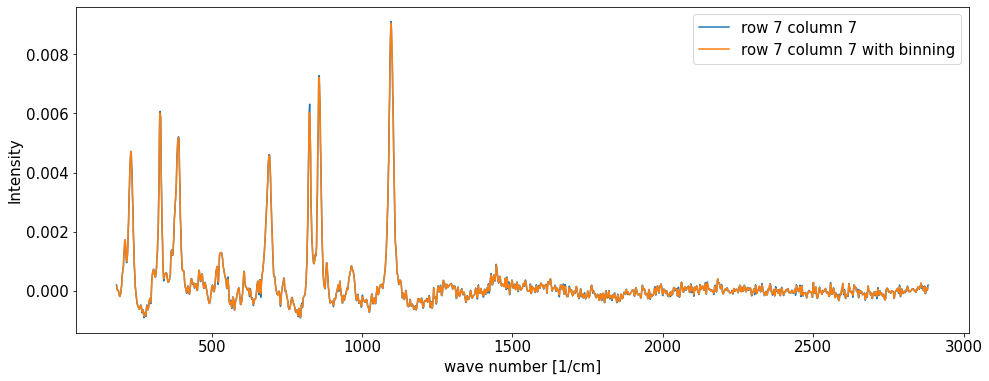

In [20]:
raman_plot()
plt.rc('font',**font)
plt.plot(data_bkg.wn,data_bkg[sample])
plt.plot(x,y);
plt.legend(['row 7 column 7','row 7 column 7 with binning' ]);

### Soglia al rumore in base alla varianza calcolata sulla coda dello spettro

Temiamo che gli algoritmi di clusterizzatione e di regressione possano "imparare" dal rumore di fondo.

Siamo interessati a riconoscere le abbondanze principali dei materiali del nostro campione possiamo trascurarlo. Per ridurre questo rumore dagli spettri sperimentali procediamo come segue.

**Ipotizziamo che il rumore non dipenda dal numero d'onda**. Calcoliamo dunque la varianza sulla coda dei grafici (che per confronto con gli spettri puri dovrebbe essere a zero) e fissiamo una soglia, in funzione della varianza, all'intensità su tutta la curva. 

I punti con intensità inferiore alla soglia (fissata a $3\sigma$) sono messi a zero.

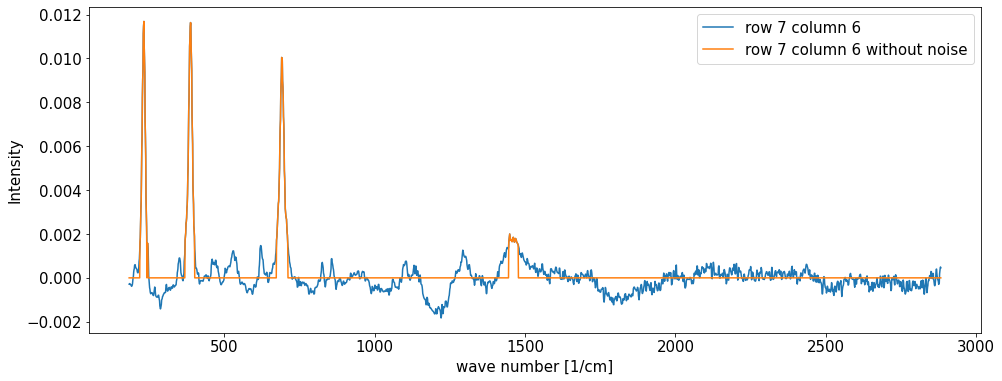

In [21]:
sample='r7c6' #il sample su cui faccio gli esempi
sigma=data_bkg[sample][element_soglia:].std() #calcolo la std
bound=3*sigma #fisso il bound del rumore a 3 volte il sigma della coda
y=data_bkg[sample].copy()
x=data_bkg.wn
for i in enumerate(y):
    if i[1]<bound:
        y[i[0]]=0

raman_plot()
plt.rc('font',**font)
plt.plot(data_bkg.wn,data_bkg[sample])
plt.plot(x,y)
plt.legend(['row 7 column 6','row 7 column 6 without noise']);

Lo faccio poi per tutti gli spettri, devo scegliere quanti sigma usare come bound.

In [22]:
n_sigma=3
for temp in names[1:]:
    bound=n_sigma*data_bkg[temp][element_soglia:].std() #calcolo la std sulla coda
    for i in enumerate(data_bkg[temp]):
        if i[1]<bound:
            data_bkg[temp][i[0]]=0

Questo è il risultato, **comunque non utilizzato nel seguito dato che abbiamo visto che non era necessario.**

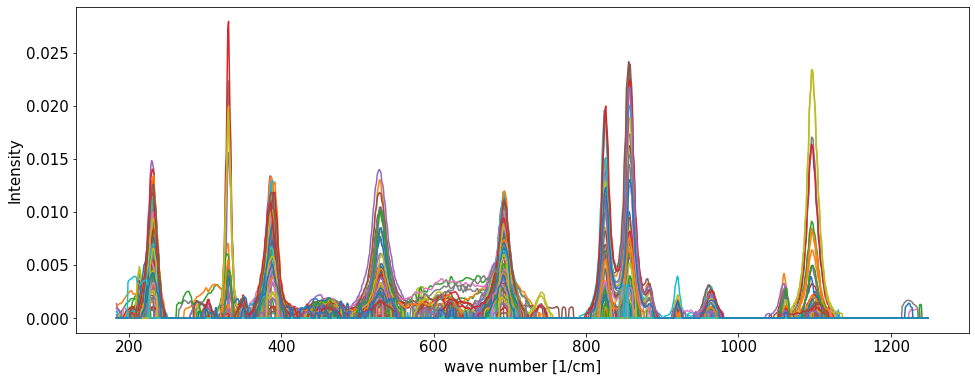

In [23]:
raman_plot()
plt.rc('font',**font)
for temp in names[1:]:
    plt.plot(data_bkg.wn[0:element_soglia],data_bkg[temp][0:element_soglia]);

## Eliminazione degli spettri "non fisici"
Non abbiamo ancora avuto il tempo di implementarlo....